# Clustering (Thuật toán phân loại không giám sát)

## Định nghĩa

**Clustering** là thuật toán phân loại **không giám sát (unsupervised learning)**.  
Khác với bài toán classification, nơi mà dữ liệu đầu vào **đã được dán nhãn (labelled)**,  
thì bài toán **Clustering** sử dụng dữ liệu đầu vào **chưa được dán nhãn (unlabelled)**.

**Ví dụ:**
- Lọc fake-news
- Phân loại khách hàng
- Phân loại sản phẩm

## Tổng quan về các thuật toán Clustering

Có rất nhiều thuật toán được sử dụng trong Clustering.  
Đối với mỗi loại dữ liệu cần dùng 1 loại thuật toán cho phù hợp nhất.  
Không có thuật toán thần kỳ nào có thể cho ra đáp án chính xác 100%.  

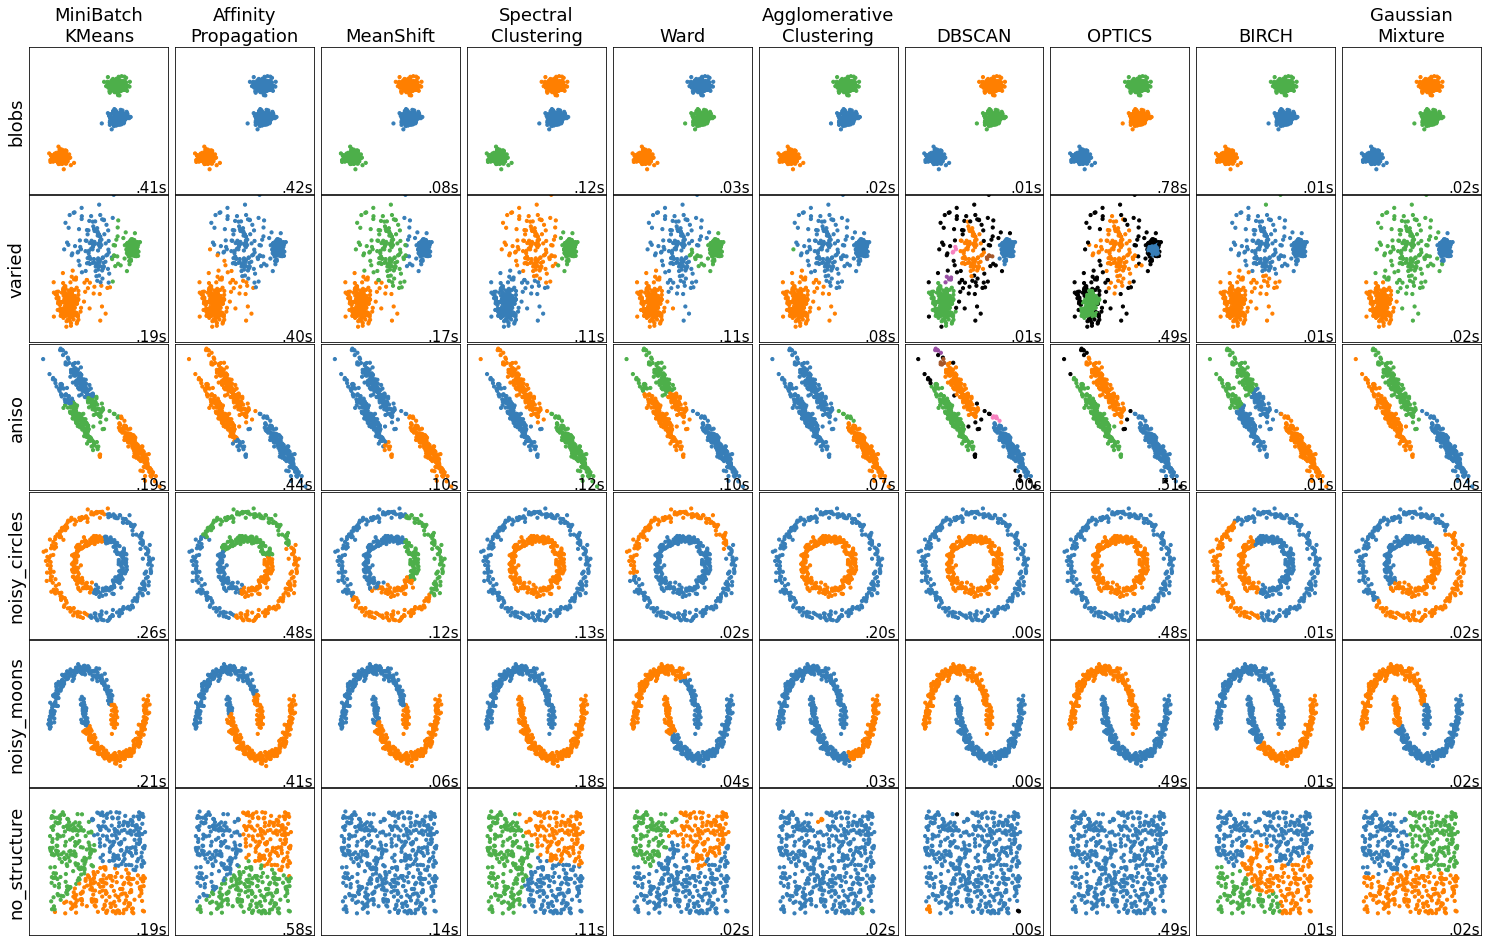

In [31]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
warnings.filterwarnings('ignore')

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets_name = ['blobs', 'varied', 'aniso', 'noisy_circles', 'noisy_moons', 'no_structure']

datasets = [
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        
        if i_dataset == 0:
            plt.title(name, size=18)
        if name=="MiniBatch\nKMeans":
            plt.ylabel(datasets_name[i_dataset], fontsize=18.0)
        
        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

**Quy trình chung của một thuật toán clustering:**  
1. Lựa chọn tâm của nhóm (cluster center)
2. Tính toán khoảng cách giữa các điểm tới tâm nhóm, hoặc giữa các tâm nhóm
3. Tái xác định tâm nhóm theo kết quả tính khoảng cách ở bước 2
4. Lặp lại các bước trên cho tới khi đạt được kết quả tối ưu

## Các thuật toán clustering

### Chuẩn bị dữ liệu demo

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import radviz
import time

#Nhập dữ liệu
dat = pd.read_csv('IRIS.csv')
dat

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [50]:
#Kiểm tra sơ bộ dữ liệu
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [51]:
#Chia dữ liệu thành 2 bộ train và test
from sklearn.model_selection import train_test_split

X = dat.drop(columns='species',axis=1)
Y = dat['species'] #Label --> ko dùng

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.3) # 30% dữ liệu là test
print(X_train.shape)  # 105 records out of 150 will be the training data
print(X_test.shape)   #  45 records out of 150 will be the testing  data

(105, 4)
(45, 4)


In [52]:
def plot_data(X, Y, TYPE):
    temp = pd.concat([X, Y], axis=1) #Tạo df từ X và Y
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    sns.scatterplot(data=temp, x='petal_length', y='petal_width', hue='species', s=50, ax=ax[0])\
    .set(title='scatter');
    radviz(temp, "species", ax=ax[1], color = ['blue', 'green', 'red'])\
    .set_title('radviz-3-kinds')
    # radviz(temp[temp['species'] != 'Iris-setosa'], "species", ax=ax[2], color = ['green', 'red']).set_title('radviz-2-kind')
    plt.suptitle(TYPE)
    plt.tight_layout()
    plt.show()

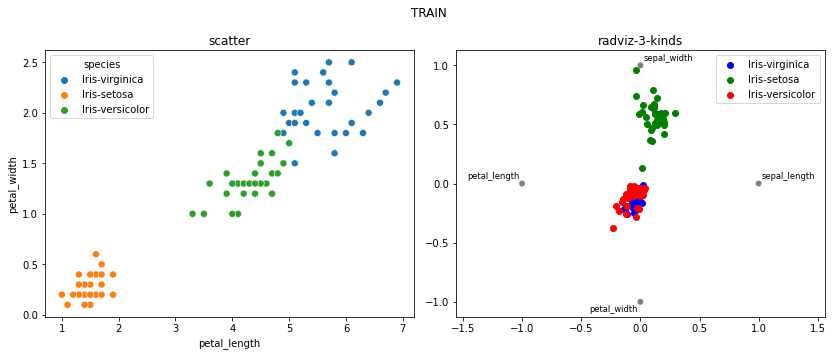

In [6]:
plot_data(X_train, Y_train, 'TRAIN')

### KMeans

#### Các thuật toán con tiêu biểu

- KMean tiêu chuẩn
- MiniBatchKMeans: tăng tốc độ tính toán bằng cách chia nhỏ dữ liệu, độ chính xác kém hơn

<img src="attachment:596c1fde-3b95-49c3-b658-0d1ec04419c9.png" alt="Drawing" style="width: 500px;"/>

#### Quy trình của thuật toán:

1. Xác định số lượng nhóm cần phân loại (đầu vào)
2. Lựa chọn tâm nhóm (random)
3. Tính toán khoảng cách giữa các điểm đến tâm nhóm
4. Dựa vào khoảng cách vừa tính được, cập nhật lại vị trí tâm nhóm mới
5. Lặp lại các bước cho đến khi hội tụ

#### Demo KMeans

In [81]:
#Khai báo thư viện
from sklearn.cluster import KMeans
# from sklearn.cluster import MiniBatchKMeans

#Tạo model
kmeans = KMeans(n_clusters=3)

start = time.time()
#Học (train)
kmeans.fit(X_train)
print(time.time()-start) #Tính thời gian

#Kết quả của train
Y_learn = kmeans.labels_ #numpy array
Y_learn = pd.Series(Y_learn, index=X_train.index) #chuyển từ np array -> pandas series
Y_learn.name = 'species' #đổi tên series
# Y_learn

0.3569982051849365


In [82]:
#Tâm của nhóm (trường hợp này không gian 4 chiều)
kmeans.cluster_centers_

array([[5.02571429, 3.40285714, 1.49714286, 0.24571429],
       [6.872     , 3.104     , 5.732     , 2.024     ],
       [5.84666667, 2.75111111, 4.43333333, 1.47777778]])

In [83]:
#Dự đoán kết quả từ dữ liệu X_test
Y_pred = kmeans.predict(X_test)
Y_pred = pd.Series(Y_pred, index=X_test.index)
Y_pred.name = 'species'
# Y_pred

In [84]:
#Thư viện
import time
from sklearn.neighbors import KNeighborsClassifier

#Tạo model
knn = KNeighborsClassifier(n_neighbors=5) #Test với n=9


start = time.time()

#fit, học, train
knn.fit(X_train,Y_train)

print('Đã học xong trong:', time.time()-start, ' s')

#dự đoán
Y_pred_knn = knn.predict(X_test)
Y_pred_knn = pd.Series(Y_pred_knn, index=X_test.index)
Y_pred_knn.name = 'species'

Đã học xong trong: 0.004998922348022461  s


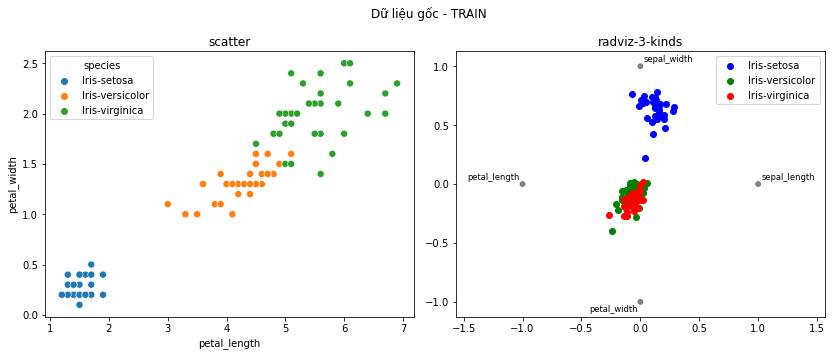

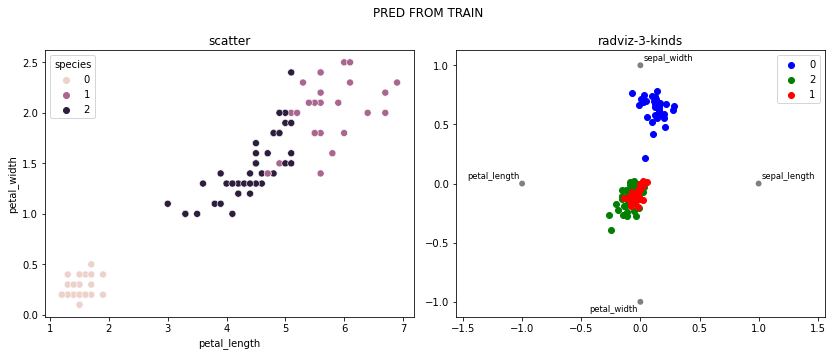

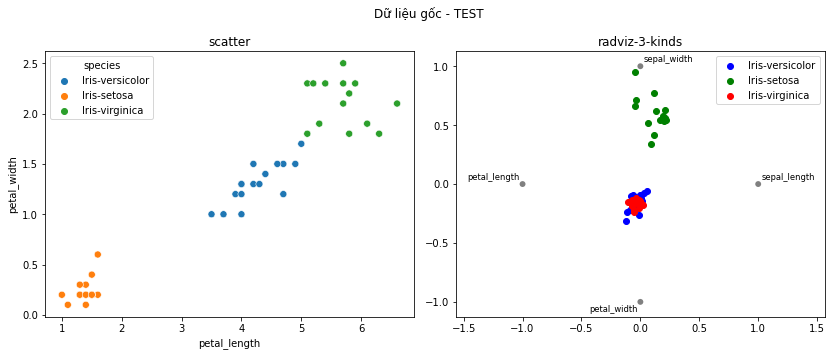

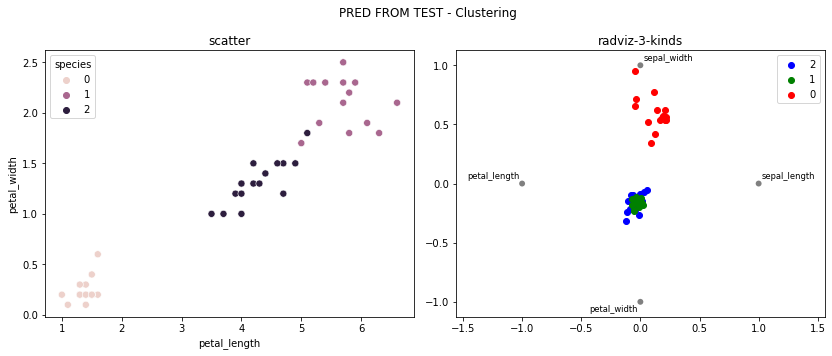

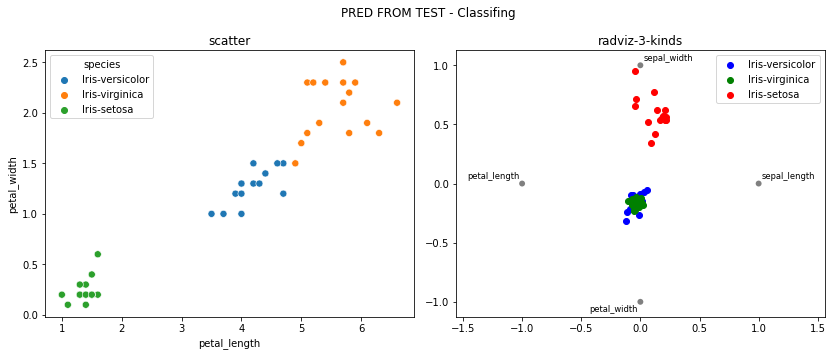

In [85]:
#Vẽ đồ thị so sánh
plot_data(X_train, Y_train, 'Dữ liệu gốc - TRAIN')
plot_data(X_train, Y_learn, 'PRED FROM TRAIN')
plot_data(X_test, Y_test, 'Dữ liệu gốc - TEST')
plot_data(X_test, Y_pred, 'PRED FROM TEST - Clustering')
plot_data(X_test, Y_pred_knn, 'PRED FROM TEST - Classifing')

#### Đánh giá model

In [16]:
from sklearn import metrics
import numpy as np

**Rand_score**

In [17]:
#Phương pháp rand_score [-1,1]
print(metrics.rand_score(Y_train, Y_learn))
print(metrics.rand_score(Y_test, Y_pred))

0.8956043956043956
0.8363636363636363


In [18]:
#Phương pháp adjusted_rand_score, [0,1]
print(metrics.adjusted_rand_score(Y_train, Y_learn))
print(metrics.adjusted_rand_score(Y_test, Y_pred))

0.7658516943363225
0.6323886713915045


**Mutual_info**

In [19]:
#Phương pháp adjusted_mutual_info_score, [0,1]
print(metrics.adjusted_mutual_info_score(Y_train, Y_learn))
print(metrics.adjusted_mutual_info_score(Y_test, Y_pred))

0.7639198886377904
0.7397750420562752


In [20]:
#Phương pháp normalized_mutual_info_score, [0,1]
print(metrics.normalized_mutual_info_score(Y_train, Y_learn))
print(metrics.normalized_mutual_info_score(Y_test, Y_pred))

0.7681820869064898
0.7514069095569623


**Homogeneity and Completeness**

In [21]:
#Phương pháp homogeneity_score: mỗi cluster chỉ chứa các phần tử chỉ thuộc về 1 class
print(metrics.homogeneity_score(Y_train, Y_learn))
print(metrics.homogeneity_score(Y_test, Y_pred))

0.7615218530965379
0.748562685974905


In [22]:
#Phương pháp completeness_score: toàn bộ các phần tử của 1 class (đã biết) thuộc về cùng 1 cluster
print(metrics.completeness_score(Y_train, Y_learn))
print(metrics.completeness_score(Y_test, Y_pred))

0.7749598487858783
0.7542728292835909


#### Demo MiniBatch-KMeans

In [36]:
#Khai báo thư viện
from sklearn.cluster import MiniBatchKMeans

#Tạo model
kmeans = MiniBatchKMeans(n_clusters=3, batch_size = 1024)

#Học (train)
start = time.time()
kmeans.fit(X_train)
print(time.time()-start)

#Kết quả của train
Y_learn = kmeans.labels_
Y_learn = pd.Series(Y_learn, index=X_train.index)
Y_learn.name = 'species'
# Y_learn

C:\Users\Hamilton\anaconda3.9\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


1.0278747081756592


In [37]:
#Tâm của nhóm (trường hợp này không gian 4 chiều)
kmeans.cluster_centers_

array([[5.03371251, 3.42812823, 1.47331954, 0.25036194],
       [5.91041852, 2.78788958, 4.37479964, 1.42831701],
       [6.96984375, 3.1046875 , 5.7875    , 2.05515625]])

In [39]:
#Dự đoán kết quả từ dữ liệu X_test
Y_pred = kmeans.predict(X_test)
Y_pred = pd.Series(Y_pred, index=X_test.index)
Y_pred.name = 'species'
# Y_pred

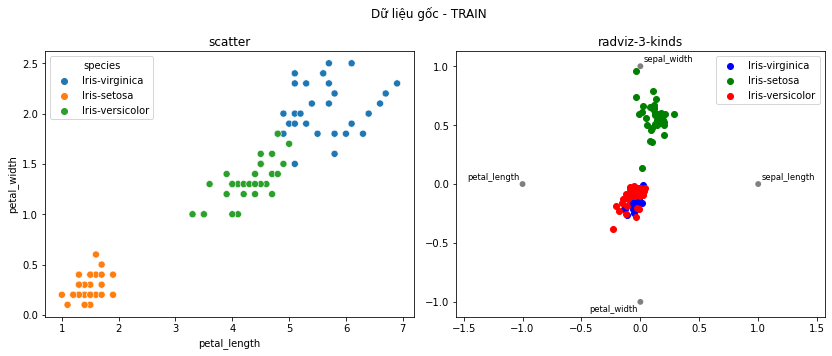

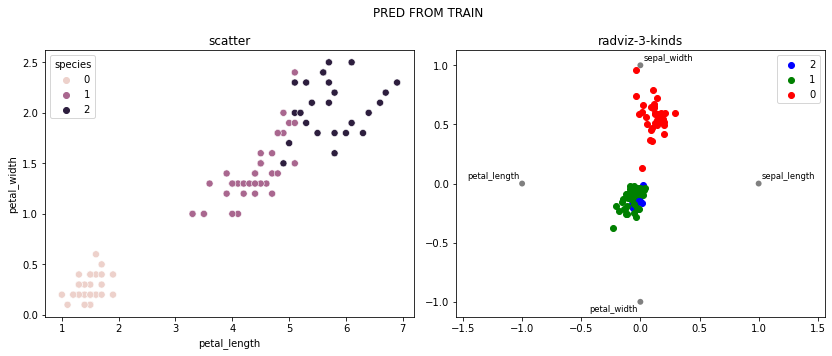

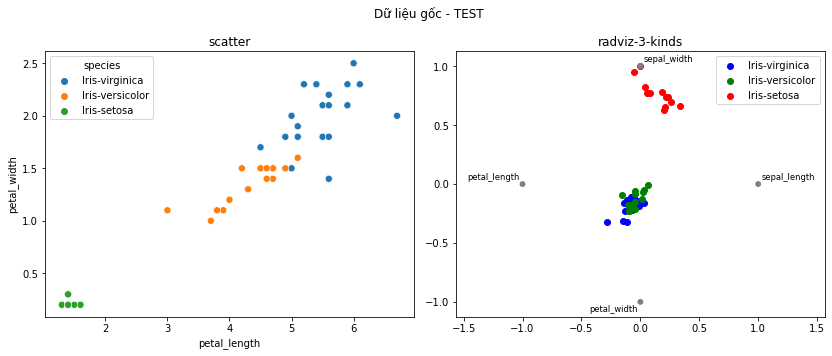

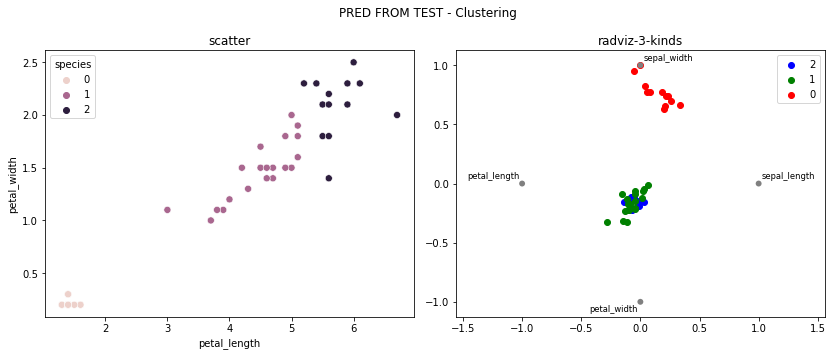

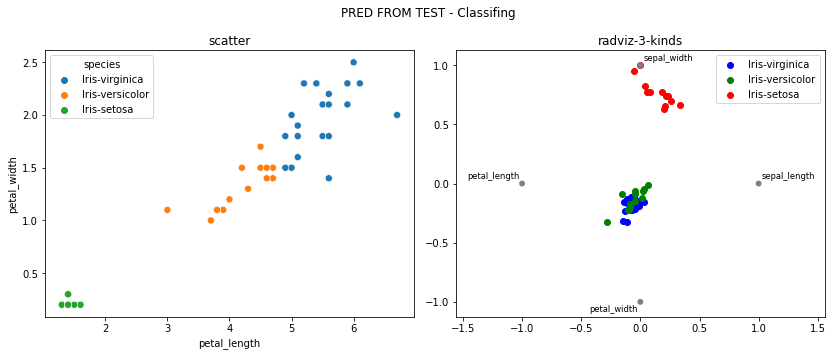

In [40]:
#Vẽ đồ thị so sánh
plot_data(X_train, Y_train, 'Dữ liệu gốc - TRAIN')
plot_data(X_train, Y_learn, 'PRED FROM TRAIN')
plot_data(X_test, Y_test, 'Dữ liệu gốc - TEST')
plot_data(X_test, Y_pred, 'PRED FROM TEST - Clustering')
plot_data(X_test, Y_pred_knn, 'PRED FROM TEST - Classifing')

#### Đánh giá model

In [41]:
from sklearn import metrics
import numpy as np

**Rand_score**

In [42]:
#Phương pháp rand_score [-1,1]
print(metrics.rand_score(Y_train, Y_learn))
print(metrics.rand_score(Y_test, Y_pred))

0.8956043956043956
0.8363636363636363


In [43]:
#Phương pháp adjusted_rand_score, [0,1]
print(metrics.adjusted_rand_score(Y_train, Y_learn))
print(metrics.adjusted_rand_score(Y_test, Y_pred))

0.7658516943363225
0.6323886713915045


**Mutual_info**

In [44]:
#Phương pháp adjusted_mutual_info_score, [0,1]
print(metrics.adjusted_mutual_info_score(Y_train, Y_learn))
print(metrics.adjusted_mutual_info_score(Y_test, Y_pred))

0.7639198886377904
0.7397750420562752


In [45]:
#Phương pháp normalized_mutual_info_score, [0,1]
print(metrics.normalized_mutual_info_score(Y_train, Y_learn))
print(metrics.normalized_mutual_info_score(Y_test, Y_pred))

0.7681820869064898
0.7514069095569623


**Homogeneity and Completeness**

In [46]:
#Phương pháp homogeneity_score: mỗi cluster chỉ chứa các phần tử chỉ thuộc về 1 class
print(metrics.homogeneity_score(Y_train, Y_learn))
print(metrics.homogeneity_score(Y_test, Y_pred))

0.7615218530965379
0.748562685974905


In [47]:
#Phương pháp completeness_score: toàn bộ các phần tử của 1 class (đã biết) thuộc về cùng 1 cluster
print(metrics.completeness_score(Y_train, Y_learn))
print(metrics.completeness_score(Y_test, Y_pred))

0.7749598487858783
0.7542728292835909


### Hierarchical

#### Quy trình của thuật toán (Agglomerative):

<img src="attachment:b05e594a-365e-498a-86dd-74353fa0589b.png" alt="Drawing" style="width: 500px;"/>

1. Mỗi phần tử được coi như là 1 nhóm
2. Sau mỗi lần học, xác định 1 tâm nhóm mới dựa trên giá trị trung bình của X và Y
3. Gộp tâm nhóm mới là điểm nằm gần nhất giữa các tâm cũ
4. Tìm tâm nhóm mới dựa trên các giá trị trung bình
5. Lặp lại các bước cho đến khi chỉ còn 1 nhóm

#### Các thuật toán con tiêu biểu

- Single Linkage
- Average Linkage
- Complete Linkage
- Ward Linkage

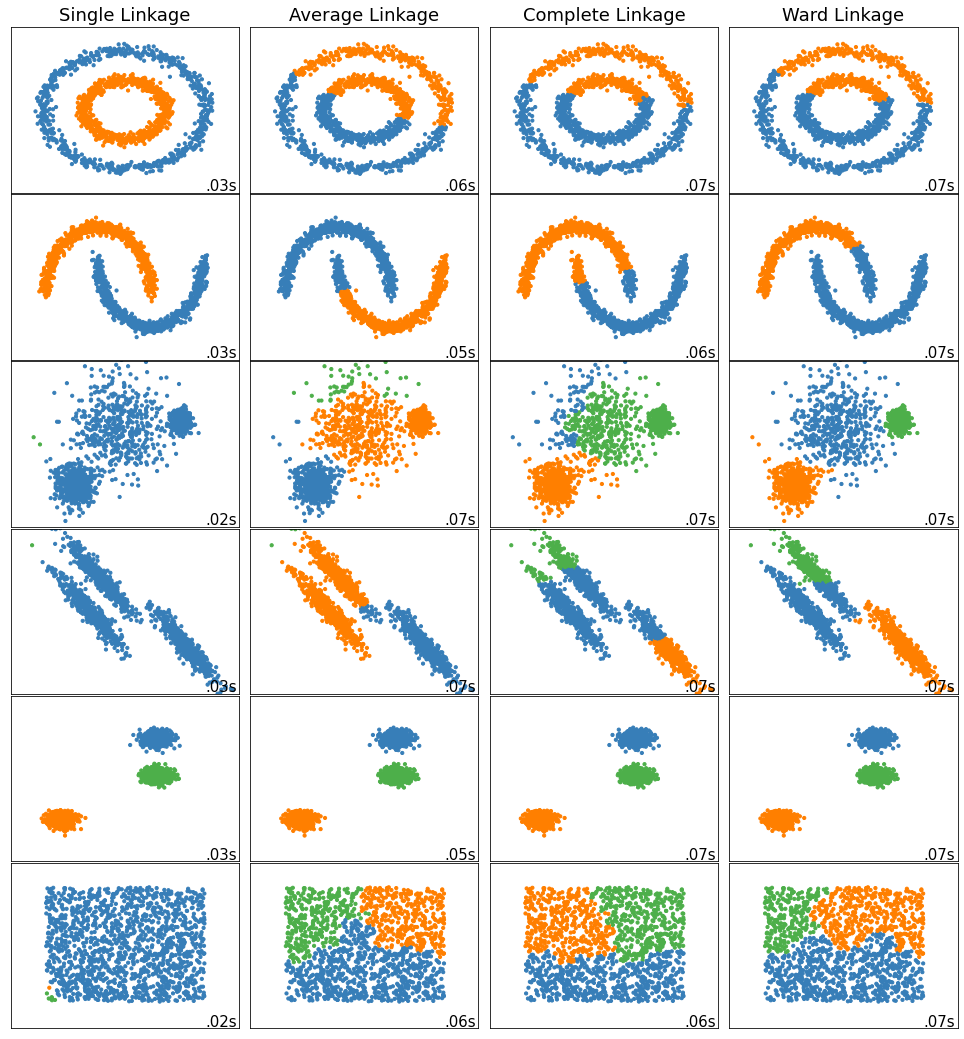

In [248]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {"n_neighbors": 10, "n_clusters": 3}

datasets = [
    (noisy_circles, {"n_clusters": 2}),
    (noisy_moons, {"n_clusters": 2}),
    (varied, {"n_neighbors": 2}),
    (aniso, {"n_neighbors": 2}),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward"
    )
    complete = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="complete"
    )
    average = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="average"
    )
    single = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="single"
    )

    clustering_algorithms = (
        ("Single Linkage", single),
        ("Average Linkage", average),
        ("Complete Linkage", complete),
        ("Ward Linkage", ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

#### Chú ý

- Không có predict
- Mỗi lần chạy là một lần học mới

#### Demo

In [165]:
#Khai báo thư viện
from sklearn.cluster import AgglomerativeClustering

# linkage = ['ward', 'complete', 'average', 'single']

#Tạo model
cluster = AgglomerativeClustering(n_clusters=3, linkage="ward")

start = time.time()
#Train
cluster.fit(X_train)
print('Thời gian học:', time.time()-start, 's')

Thời gian học: 0.0050051212310791016 s


In [166]:
#Lấy kết quả
Y_pred = cluster.labels_
Y_pred = pd.Series(Y_pred, index=X_train.index)
Y_pred.name = 'species'

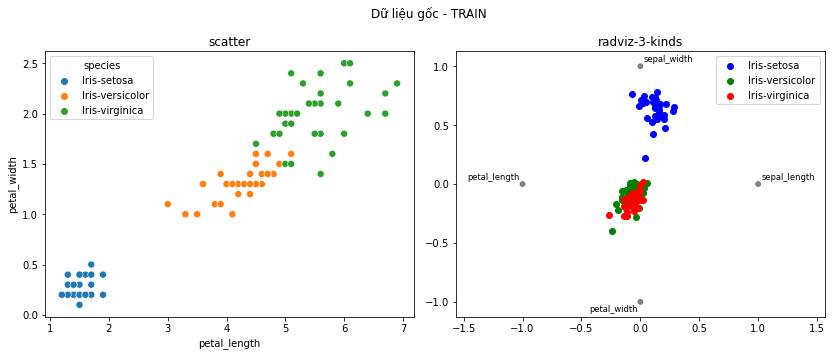

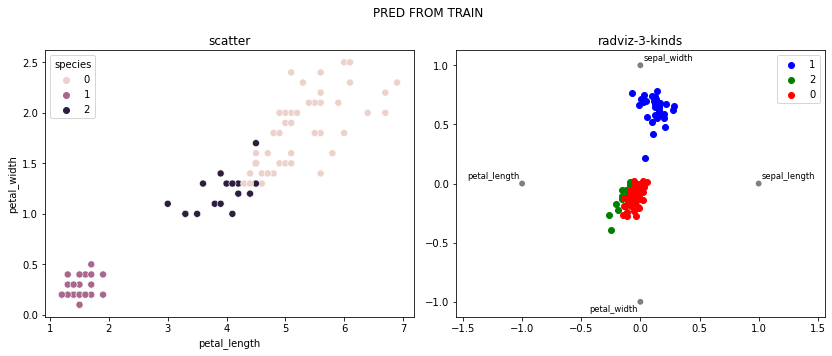

In [167]:
#Vẽ đồ thị so sánh
plot_data(X_train, Y_train, 'Dữ liệu gốc - TRAIN')
plot_data(X_train, Y_pred, 'PRED FROM TRAIN')
# plot_data(X_test, Y_test, 'Dữ liệu gốc - TEST')
# plot_data(X_test, Y_pred, 'PRED FROM TEST - Clustering')
# plot_data(X_test, Y_pred_knn, 'PRED FROM TEST - Classifing')

#### Đánh giá model

In [168]:
from sklearn import metrics
import numpy as np

**Rand_score**

In [169]:
#Phương pháp rand_score [-1,1]
print(metrics.rand_score(Y_train, Y_pred))

0.834981684981685


In [170]:
#Phương pháp adjusted_rand_score, [0,1]
print(metrics.adjusted_rand_score(Y_train, Y_pred))

0.6384070877638227


**Mutual_info**

In [171]:
#Phương pháp adjusted_mutual_info_score, [0,1]
print(metrics.adjusted_mutual_info_score(Y_train, Y_pred))

0.7089800513600378


In [172]:
#Phương pháp normalized_mutual_info_score, [0,1]
print(metrics.normalized_mutual_info_score(Y_train, Y_pred))

0.7143723159614171


**Homogeneity and Completeness**

In [173]:
#Phương pháp homogeneity_score: mỗi cluster chỉ chứa các phần tử chỉ thuộc về 1 class
print(metrics.homogeneity_score(Y_train, Y_pred))

0.690943563409455


In [174]:
#Phương pháp completeness_score: toàn bộ các phần tử của 1 class (đã biết) thuộc về cùng 1 cluster
print(metrics.completeness_score(Y_train, Y_pred))

0.7394456955305264


### DBSCAN (Density-Based Spatial Clustering of Applications and Noise)

#### Quy trình của thuật toán:

<img src="attachment:e20e0fba-c423-4284-8f93-91026d423793.png" alt="Drawing" style="width: 500px;"/>

Thuật toán này giả sử một nhóm là vùng mà có mật độ các phần tử cao hơn, và các nhóm được chia tách bởi các vùng có mật độ thấp

1. Xác định 'core sample' là nhóm có mật độ cao nhất
2. Xác định các nhóm phụ
3. Tính toán min_sample (số nhóm tối thiểu) và eps (mật độ)
4. Tính toán cho đến khi số nhóm là nhỏ nhất và mật độ là lớn nhất

#### Các thuật toán con tiêu biểu

- DBSCAN
- OPTICS

#### Chú ý

- DBSCAN luôn cho ra cùng 1 kết quả nếu thứ tự dữ liệu đầu vào là giống nhau
- Tuy nhiên, kết quả có thể khác nếu dữ liệu đầu vào sắp xếp theo thứ tự khác
- Nếu dữ liệu đầu vào khó xác định core-sample thì kết quả có thể khác sau mỗi lần chạy
- Sẽ có những dữ liệu không thuộc nhóm nào (noise)
- Không có predict

#### Demo

In [154]:
#Nhập thư viện
from sklearn.cluster import DBSCAN

#Tạo model
db = DBSCAN(eps=0.6, min_samples=3)

start = time.time()
#Train
db.fit(X_train)
print('Thời gian tính toán:', time.time()-start, 's')

Thời gian tính toán: 0.010022878646850586 s


In [155]:
labels = db.labels_
labels

array([ 0,  1, -1,  1,  0,  1,  0,  1,  0,  0,  1,  1,  1,  0,  1, -1,  1,
        1,  0,  1,  1,  0,  1,  1,  1,  1,  0,  0,  0, -1,  0, -1,  2, -1,
        0,  1,  1,  1,  1,  1,  0,  0, -1,  1,  0,  1,  1,  1,  1,  1,  0,
        0,  0,  0,  0,  1,  1,  1,  1,  0,  1,  1,  1,  1,  0,  1,  1,  0,
        1,  0,  1,  0,  1,  1,  1,  1,  1,  1,  2,  0, -1,  2,  0,  1, -1,
        1,  1,  1,  0,  1,  1,  1,  0,  0,  1,  0,  0,  1,  0,  1,  1,  1,
        1,  1,  2], dtype=int64)

In [156]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(n_clusters_, n_noise_)

3 8


In [157]:
#Lấy kết quả
Y_pred = db.labels_
Y_pred = pd.Series(Y_pred, index=X_train.index)
Y_pred.name = 'species'

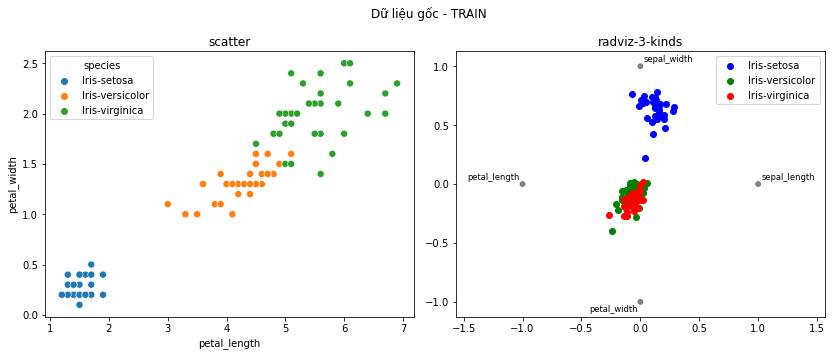

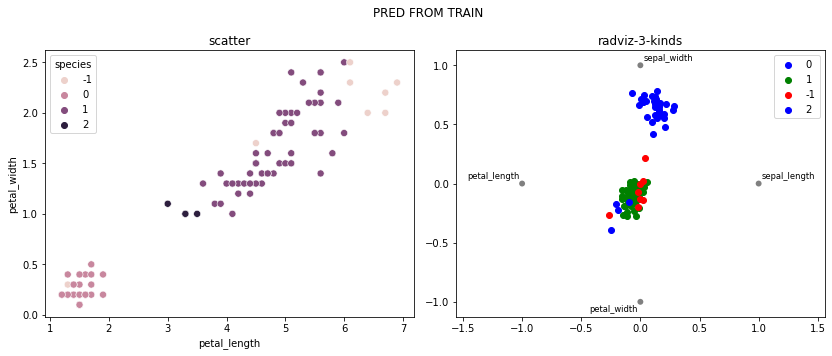

In [158]:
#Vẽ đồ thị so sánh
plot_data(X_train, Y_train, 'Dữ liệu gốc - TRAIN')
plot_data(X_train, Y_pred, 'PRED FROM TRAIN')
# plot_data(X_test, Y_test, 'Dữ liệu gốc - TEST')
# plot_data(X_test, Y_pred, 'PRED FROM TEST - Clustering')
# plot_data(X_test, Y_pred_knn, 'PRED FROM TEST - Classifing')

#### Đánh giá model

In [41]:
from sklearn import metrics
import numpy as np

**Rand_score**

In [159]:
#Phương pháp rand_score [-1,1]
print(metrics.rand_score(Y_train, Y_pred))

0.773992673992674


In [160]:
#Phương pháp adjusted_rand_score, [0,1]
print(metrics.adjusted_rand_score(Y_train, Y_pred))

0.5223323338027553


**Mutual_info**

In [161]:
#Phương pháp adjusted_mutual_info_score, [0,1]
print(metrics.adjusted_mutual_info_score(Y_train, Y_pred))

0.6340535420658445


In [162]:
#Phương pháp normalized_mutual_info_score, [0,1]
print(metrics.normalized_mutual_info_score(Y_train, Y_pred))

0.6453816335333096


**Homogeneity and Completeness**

In [163]:
#Phương pháp homogeneity_score: mỗi cluster chỉ chứa các phần tử chỉ thuộc về 1 class
print(metrics.homogeneity_score(Y_train, Y_pred))

0.6193271382391549


In [164]:
#Phương pháp completeness_score: toàn bộ các phần tử của 1 class (đã biết) thuộc về cùng 1 cluster
print(metrics.completeness_score(Y_train, Y_pred))

0.6737245765861993


### Gaussian Mixture Models (GMM)

#### Quy trình của thuật toán:

<img src="attachment:59c99351-5a52-4090-814a-0e17b84186d2.png" alt="Drawing" style="width: 500px;"/>

Thuật toán này pha trộn giữa k-means và dbscan

#### Các thuật toán con tiêu biểu

- Gaussian mixture
- Bayesian Gaussian Mixture

#### Demo

In [142]:
from sklearn.mixture import GaussianMixture

#Tạo model
gmm = GaussianMixture(n_components=3, covariance_type="full")

start = time.time()
#Train
gmm.fit(X_train)
print('Thời gian tính toán:', time.time()-start, 's')

Thời gian tính toán: 0.15199875831604004 s


In [143]:
#Dự đoán
Y_learn = gmm.predict(X_train)
Y_learn = pd.Series(Y_learn, index=X_train.index)
Y_learn.name = 'species'

In [144]:
Y_pred = gmm.predict(X_test)
Y_pred = pd.Series(Y_pred, index=X_test.index)
Y_pred.name = 'species'

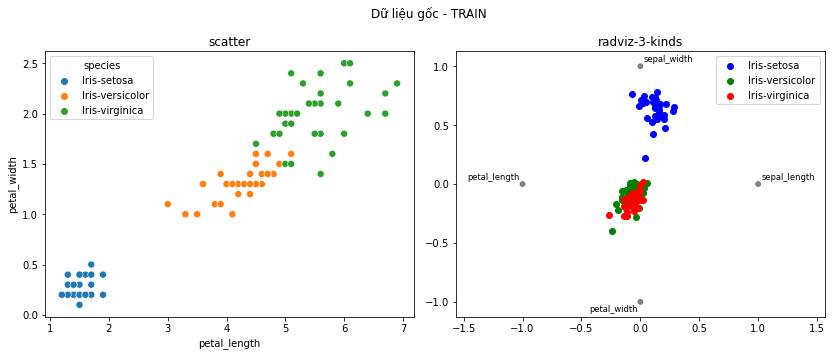

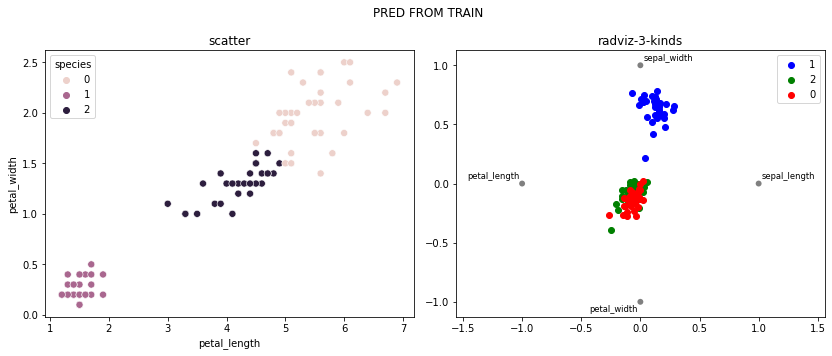

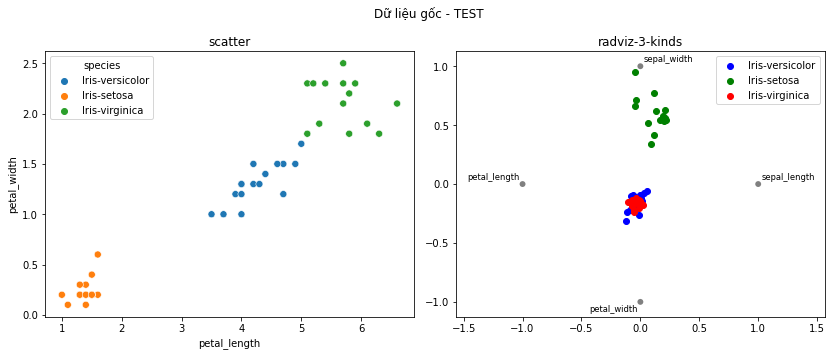

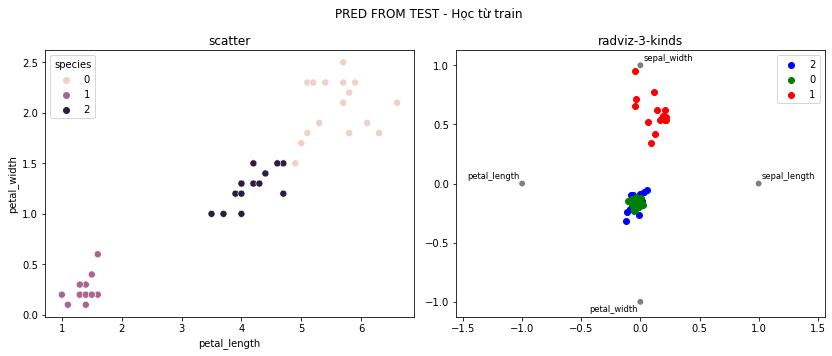

In [146]:
#Vẽ đồ thị so sánh
plot_data(X_train, Y_train, 'Dữ liệu gốc - TRAIN')
plot_data(X_train, Y_learn, 'PRED FROM TRAIN')
plot_data(X_test, Y_test, 'Dữ liệu gốc - TEST')
plot_data(X_test, Y_pred, 'PRED FROM TEST - Học từ train')

#### Đánh giá model

In [147]:
from sklearn import metrics
import numpy as np

**Rand_score**

In [148]:
#Phương pháp rand_score [-1,1]
print(metrics.rand_score(Y_train, Y_learn))
print(metrics.rand_score(Y_test, Y_pred))

0.9631868131868132
0.9434343434343434


In [149]:
#Phương pháp adjusted_rand_score, [0,1]
print(metrics.adjusted_rand_score(Y_train, Y_learn))
print(metrics.adjusted_rand_score(Y_test, Y_pred))

0.9165546925420671
0.8698493783570597


**Mutual_info**

In [150]:
#Phương pháp adjusted_mutual_info_score, [0,1]
print(metrics.adjusted_mutual_info_score(Y_train, Y_learn))
print(metrics.adjusted_mutual_info_score(Y_test, Y_pred))

0.9083504403976203
0.8723665433538869


In [151]:
#Phương pháp normalized_mutual_info_score, [0,1]
print(metrics.normalized_mutual_info_score(Y_train, Y_learn))
print(metrics.normalized_mutual_info_score(Y_test, Y_pred))

0.9099859457556878
0.8778970954433879


**Homogeneity and Completeness**

In [152]:
#Phương pháp homogeneity_score: mỗi cluster chỉ chứa các phần tử chỉ thuộc về 1 class
print(metrics.homogeneity_score(Y_train, Y_learn))
print(metrics.homogeneity_score(Y_test, Y_pred))

0.908291177303604
0.8778970954433879


In [153]:
#Phương pháp completeness_score: toàn bộ các phần tử của 1 class (đã biết) thuộc về cùng 1 cluster
print(metrics.completeness_score(Y_train, Y_learn))
print(metrics.completeness_score(Y_test, Y_pred))

0.911687050522538
0.8778970954433879
